In [4]:
test = {}
for i in range(5):
    test[i] = {a: 0.25 for a in range(4)}

print(test[0])

{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

class GridWorld:
    ACTIONS = {
        0: (-1, 0),  # UP
        1: (1, 0),   # DOWN
        2: (0, -1),  # LEFT
        3: (0, 1)    # RIGHT
    }
    ACTION_NAMES = {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}
    ACTION_ARROWS = {0: "↑", 1: "↓", 2: "←", 3: "→"}

    def __init__(self, height=5, width=5, start=(0, 0), goal=(4, 4), step_penalty=-1, goal_reward=5.0):
        self.height = height
        self.width = width
        self.start = start
        self.goal = goal
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward

    def state_index(self, row, col):
        """
            Cell (0, 0) → state 0
            Cell (0, 1) → state 1
            Cell (1, 0) → state 5
        """
        return row * self.width + col

    def state_coords(self, state):
        """
        divmod(a, b) = (a // b, a % b)
        """
        return divmod(state, self.width)

    def random_policy(self):
        policy = {}
        for s in range(self.width * self.height):
            policy[s] = {a: 1.0 / len(self.ACTIONS) for a in self.ACTIONS}
        return policy

    def reward(self, state):
        row, col = self.state_coords(state)
        return self.goal_reward if (row, col) == self.goal else self.step_penalty

    def step(self, state, action):
        row, col = self.state_coords(state)
        dr, dc = self.ACTIONS[action]

        nr, nc = row + dr, col + dc
        nr = max(0, min(self.height - 1, nr))
        nc = max(0, min(self.width - 1, nc))

        next_state = self.state_index(nr, nc)
        reward = self.reward(next_state)
        done = (nr, nc) == self.goal
        return next_state, reward, done

    def deterministic_policy(self, stochastic_policy):
        policy = {}
        rewards = {}

        for s in range(self.width * self.height):
            max_prob = max(stochastic_policy[s].values())
            best_actions = [a for a, p in stochastic_policy[s].items() if abs(p - max_prob) < 1e-8]
            chosen_action = random.choice(best_actions)
            policy[s] = {a: 1.0 if a == chosen_action else 0.0 for a in self.ACTIONS}
            rewards[s] = self.reward(s)

        return policy, rewards

    def run_episode(self, policy, max_steps=50, gamma=0.99):
        state = self.state_index(*self.start)
        trajectory = [state]
        rewards = [0]   # discounted returns
        total_reward = 0
        discount = 1.0

        for _ in range(max_steps):
            # Pick greedy action
            action = max(policy[state], key=policy[state].get)
            next_state, r, done = self.step(state, action)

            # Apply discount factor
            total_reward += discount * r
            discount *= gamma

            trajectory.append(next_state)
            rewards.append(total_reward)

            state = next_state
            if done:
                break

        return trajectory, rewards


    def visualise_episode(self, policy, cols=5):
        """Static plots of agent moving step by step in a row/column grid layout."""
        trajectory, rewards = self.run_episode(policy)
        n_steps = len(trajectory)

        rows = (n_steps + cols - 1) // cols  # ceil division
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

        # Flatten axes for easy iteration
        axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

        for i in range(n_steps):
            ax = axes[i]
            # Draw grid
            for x in range(self.width + 1):
                ax.plot([x, x], [0, self.height], color="black")
            for y in range(self.height + 1):
                ax.plot([0, self.width], [y, y], color="black")

            # Mark start & goal
            sr, sc = self.start
            gr, gc = self.goal
            ax.text(sc + 0.5, self.height - sr - 0.5, "S", ha="center", va="center",
                    fontsize=14, color="blue", fontweight="bold")
            ax.text(gc + 0.5, self.height - gr - 0.5, "T", ha="center", va="center",
                    fontsize=14, color="green", fontweight="bold")

            # Mark agent
            row, col = self.state_coords(trajectory[i])
            ax.plot(col + 0.5, self.height - row - 0.5, "ro", markersize=12)

            # Title with step and cumulative reward
            ax.set_title(f"Step {i}\nReward={rewards[i]:.1f}")

            ax.set_xlim(0, self.width)
            ax.set_ylim(0, self.height)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

        # Hide unused subplots
        for j in range(n_steps, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def visualise_policy(self, policy, title="Policy"):
        """Show the deterministic/stochastic policy with arrows in the grid."""
        fig, ax = plt.subplots(figsize=(self.width, self.height))

        # Draw grid
        for x in range(self.width + 1):
            ax.plot([x, x], [0, self.height], color="black")
        for y in range(self.height + 1):
            ax.plot([0, self.width], [y, y], color="black")

        for row in range(self.height):
            for col in range(self.width):
                s = self.state_index(row, col)
                x, y = col + 0.5, self.height - row - 0.5

                if (row, col) == self.goal:
                    ax.text(x, y, "T", ha="center", va="center", fontsize=16,
                            color="green", fontweight="bold")
                else:
                    # Best actions
                    max_prob = max(policy[s].values())
                    best_actions = [a for a, p in policy[s].items() if abs(p - max_prob) < 1e-8]

                    arrows = "".join([self.ACTION_ARROWS[a] for a in best_actions])
                    ax.text(x, y, arrows, ha="center", va="center", fontsize=14, color="red")

        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        plt.show()


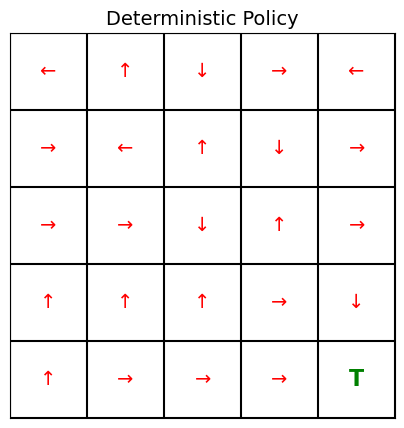

In [44]:
# Create environment
env = GridWorld(height=5, width=5, start=(0, 0), goal=(4, 4))

# Random stochastic policy
stochastic_policy = env.random_policy()

# Convert to deterministic
policy, rewards = env.deterministic_policy(stochastic_policy)

# Show the arrows of the policy
env.visualise_policy(policy, title="Deterministic Policy")


(0, 0)


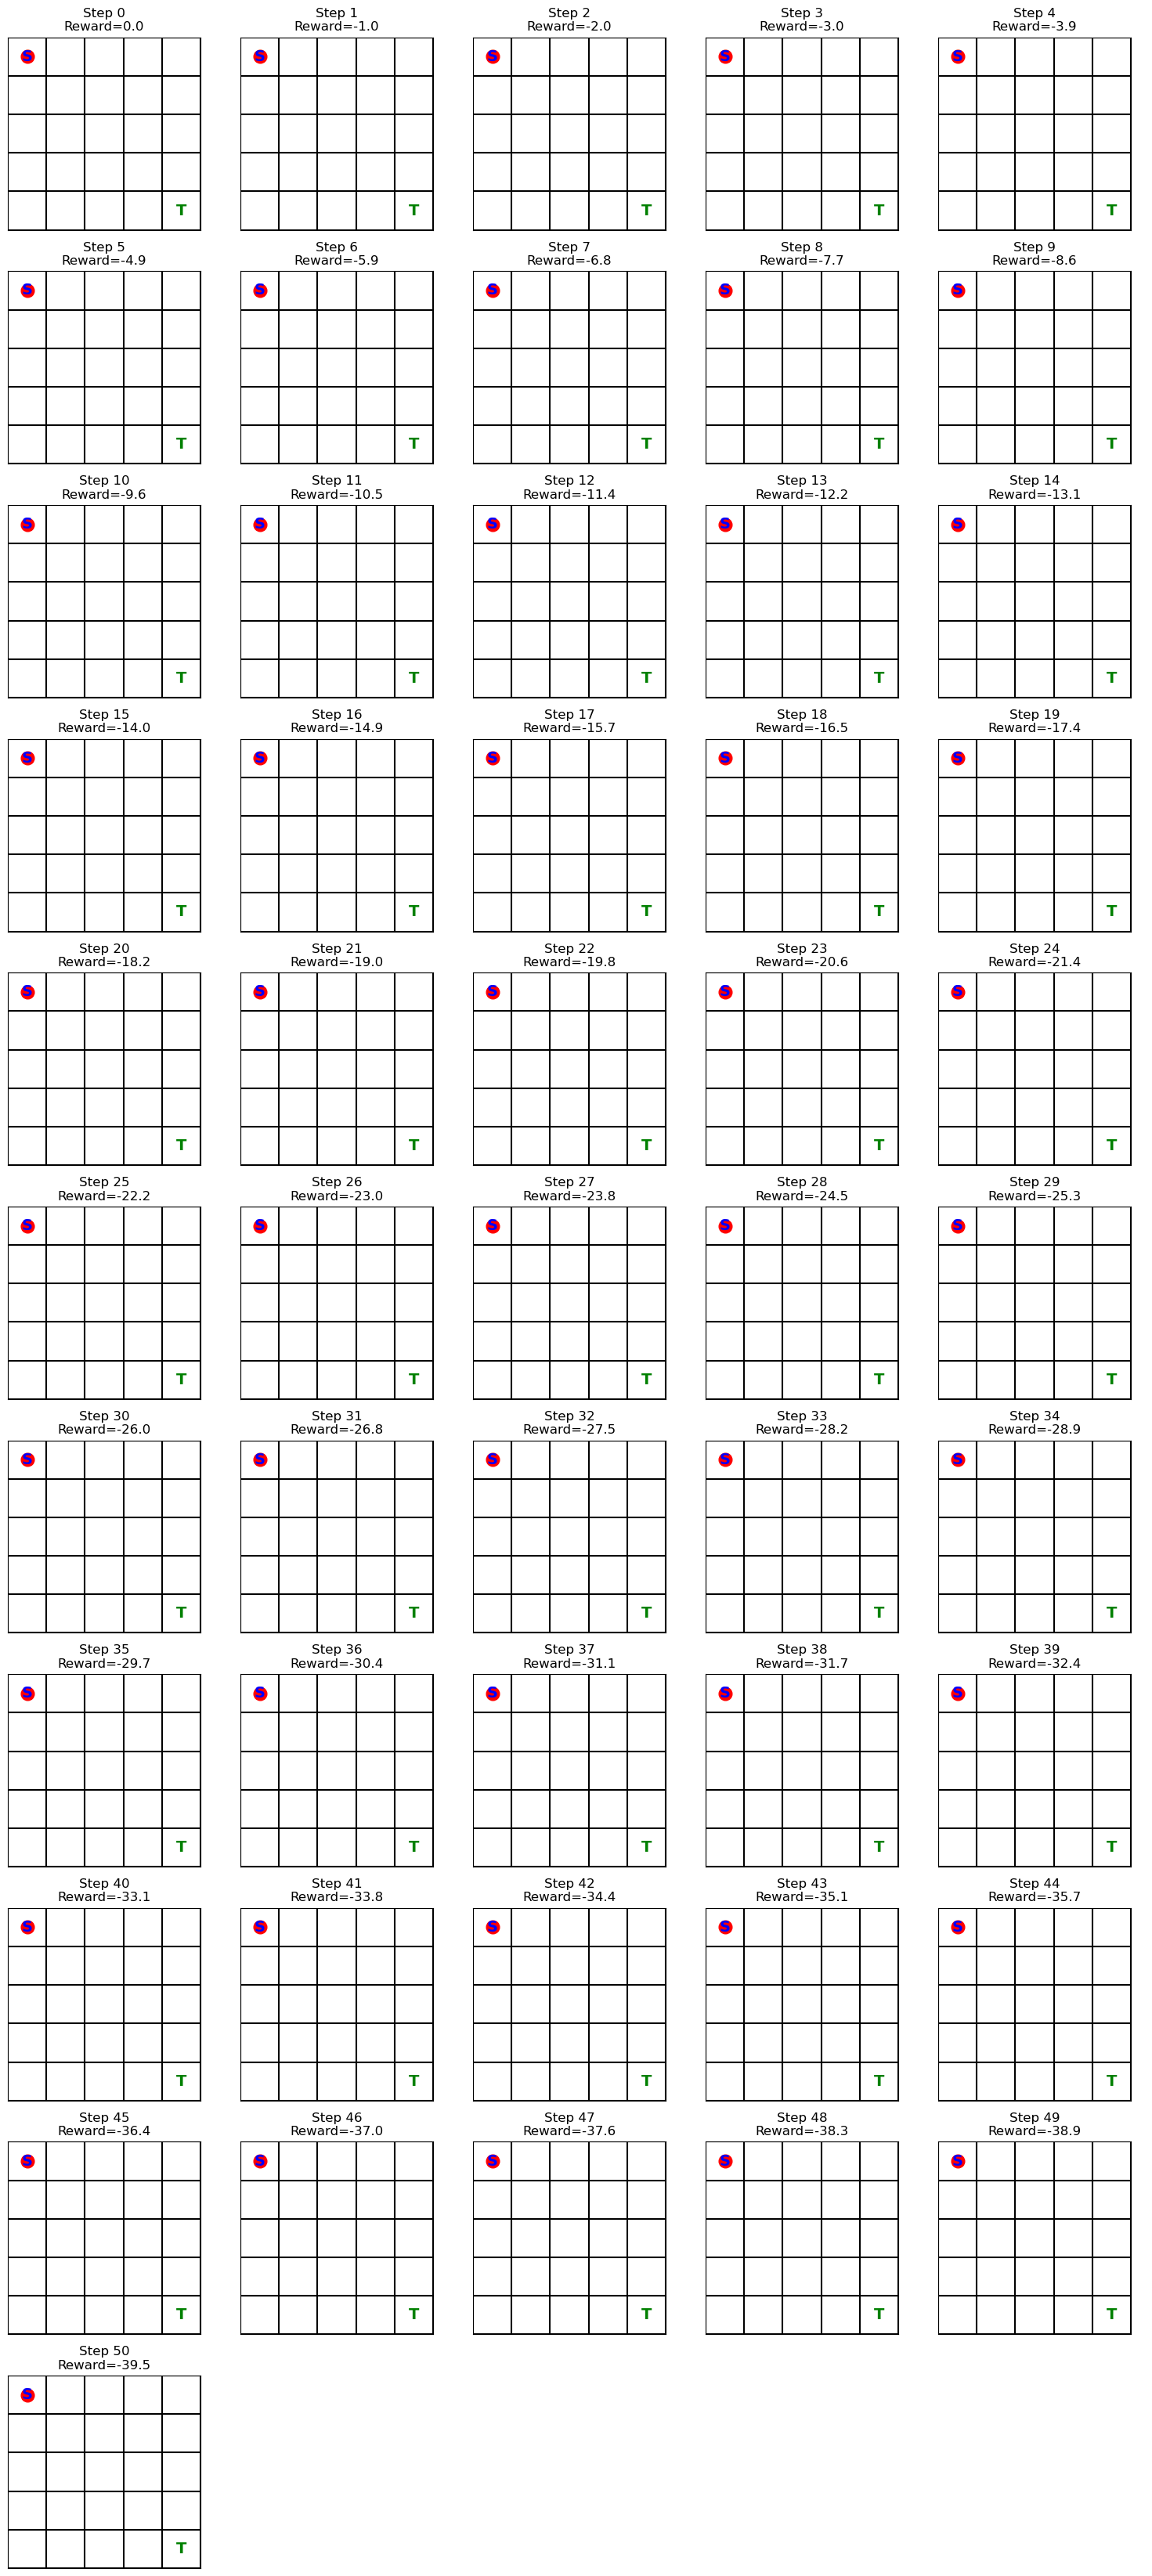

In [45]:
print(f"{env.start}")
env.visualise_episode(policy)
